In [7]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from time import time

In [15]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_max_depth1 = 3
best_lr1 = 0.3
best_gamma1 = 0
best_reg_lambda1 = 0.2
best_n_estimators1 = 7

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_max_depth2 = 9
best_lr2 = 0.05
best_gamma2 = 0.2
best_reg_lambda2 = 0.2
best_n_estimators2 = 146

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(columns=['round_winner'])
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_max_depth3 = 9
best_lr3 = 0.1
best_gamma3 = 0.3
best_reg_lambda3 = 0
best_n_estimators3 = 62

datasets = [(X1, y1, ds1_name, best_max_depth1, best_lr1, best_gamma1, best_reg_lambda1, best_n_estimators1),
            (X2, y2, ds2_name, best_max_depth2, best_lr2, best_gamma2, best_reg_lambda2, best_n_estimators2),
            (X3, y3, ds3_name, best_max_depth3, best_lr3, best_gamma3, best_reg_lambda3, best_n_estimators3)]

Dataset: match_data - Best max_depth: 3, Best learning rate: 0.3, Best gamma: 0, Best reg_lambda: 0.2, Best n_estimators: 7
Time to fit and predict: 0.013524055480957031 seconds
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       252
           1       0.65      0.71      0.68       259

    accuracy                           0.66       511
   macro avg       0.66      0.65      0.65       511
weighted avg       0.66      0.66      0.65       511

                 Predicted Negative  Predicted Positive
Actual Negative                 152                 100
Actual Positive                  76                 183
ROC AUC: 0.6984969663541092
Dataset: rounds_data - Best max_depth: 9, Best learning rate: 0.05, Best gamma: 0.2, Best reg_lambda: 0.2, Best n_estimators: 146
Time to fit and predict: 1.5920650959014893 seconds
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1148
        

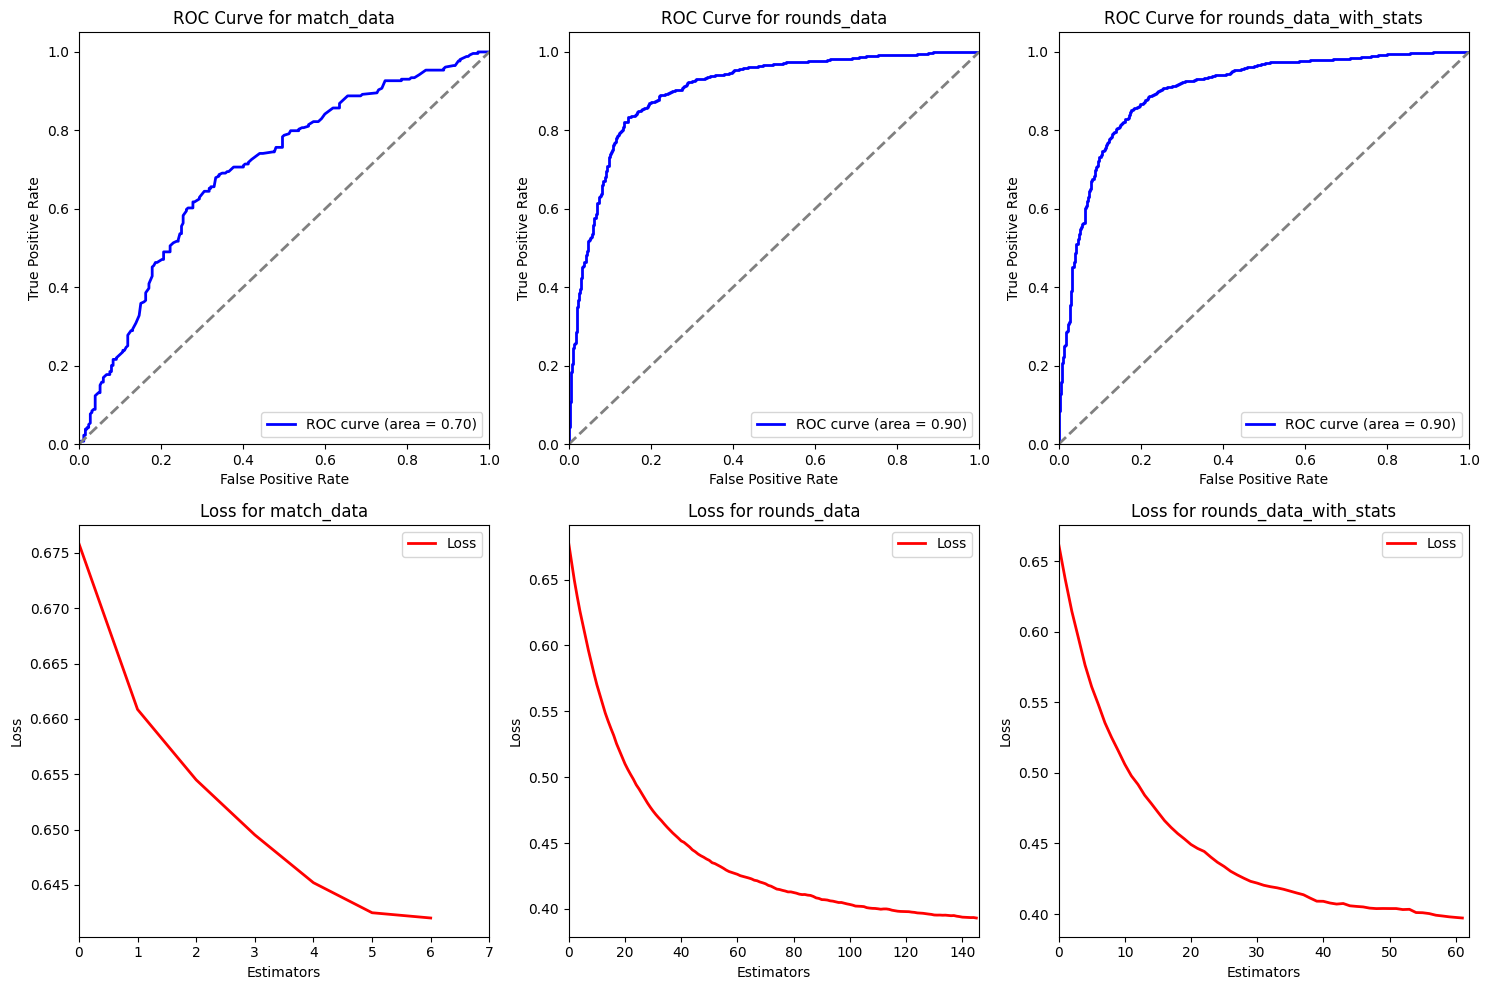

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, (X, y, ds_name, best_max_depth, best_lr, best_gamma, best_reg_lambda, best_n_estimators) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = XGBClassifier(eval_metric='logloss', n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_lr, gamma=best_gamma, reg_lambda=best_reg_lambda,
                          early_stopping_rounds=20, verbosity=0)
    
    start_time = time()

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    results = model.evals_result()['validation_0']['logloss']

    print(f"Dataset: {ds_name} - Best max_depth: {best_max_depth}, Best learning rate: {best_lr}, Best gamma: {best_gamma}, Best reg_lambda: {best_reg_lambda}, Best n_estimators: {best_n_estimators}")
    print(f"Time to fit and predict: {time() - start_time} seconds")

    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs)}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    axs[0, idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs):.2f})')
    axs[0, idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[0, idx].set_xlim([0.0, 1.0])
    axs[0, idx].set_ylim([0.0, 1.05])
    axs[0, idx].set_xlabel('False Positive Rate')
    axs[0, idx].set_ylabel('True Positive Rate')
    axs[0, idx].set_title(f'ROC Curve for {ds_name}')
    axs[0, idx].legend(loc='lower right')

    boosting_iterations = len(results)
    axs[1, idx].plot(range(boosting_iterations), results, color='red', lw=2, label='Loss')
    axs[1, idx].set_xlim([0, boosting_iterations])
    axs[1, idx].set_xlabel('Estimators')
    axs[1, idx].set_ylabel('Loss')
    axs[1, idx].set_title(f'Loss for {ds_name}')
    axs[1, idx].legend(loc='upper right')

plt.tight_layout()
plt.show()